<details>

<style>
:root {
  --ucsb-navy: #003660;
  --ucsb-gold: #FFCC00;
}

/* --- FIX SMALL FONT FROM VS CODE EXPORT --- */
html, body {
  font-size: 20px !important;        /* your main body size */
  line-height: 1.6 !important;
  font-family: "Times New Roman", serif !important;
}

div.jp-RenderedMarkdown {
    font-size: 20px !important;
    line-height: 1.7 !important;
    font-family: "Times New Roman", serif !important;
}

/* Handle notebook render wrappers */
div.rendered_html,
div.text_cell_render,
#notebook-container,
#rendered-cell,
div.jp-Notebook {
  font-size: 20px !important;
  line-height: 1.6 !important;
  font-family: "Times New Roman", serif !important;
}

/* Paragraphs, lists, anything inside markdown */
div.rendered_html p,
div.rendered_html li,
div.rendered_html span,
.text_cell_render p,
.text_cell_render li,
.text_cell_render span {
  font-size: 20px !important;
}

/* Headings */
h1, h2, h3 {
  color: var(--ucsb-navy) !important;
  font-family: "Times New Roman", serif !important;
  font-weight: 700 !important;
}

h1 { font-size: 40px !important; }
h2 { font-size: 28px !important; }
h3 { font-size: 24px !important; }

/* Code blocks */
pre, code {
  font-size: 16px !important;
  border-left: 4px solid var(--ucsb-gold);
  padding-left: 10px;
}
</style>

</details>


# Stability Selection: Reproducing and Extending Meinshausen & Bühlmann (2010) 
## Aarti Garaye 
### Final Project — PSTAT 234: Statistical Data Science, Prof. Sang Yun-Oh
### UC Santa Barbara

December 8, 2025

# 1 Abstract

Estimation of structure, such as in variable selection, graphical modelling or cluster analysis, is notoriously difficult, especially for high dimensional data. Challenges with estimation of discrete structures include computational aspects, since corresponding optimization problems are discrete, as well as determining the right amount of regularization, e.g. in an asymptotic sense for consistent structure estimation. Meinshausen & Bühlmann (2010) proposed a way to make variable selection robust by extending existing methods using a generic subsampling method. They show that subsampling can be used to determine the
amount of regularization such that a certain familywise type I error rate in multiple testing can be conservatively controlled for finite sample size. In other words, this selection method gives us some control over false positives that tend to show up in high dimensional correlated dataset. 

Stability selection is a method of improving feature selection by using subsampling with a base selection algorithm (eg. Lasso) to compute selection probabilities for each variables. Variables that are selected frequently across subsamples are considered 'stable'. This notebook reproduces a simple simulation example and extends it by varying correlation and sample size.

It is especially helpful when we are working with data that has more variables than the observations in the sample. The problem the paper is trying to solve is to select the variables that matter. Methods like lasso will select variables but small changes in the data results in a completely different set of variables. Cross validation tends to pick too many varibles, and picking a tuning parameter is tedious with common occurance of false positives. 

The idea of stability selection is Instead of trusting the variable selection method once, we subsample the data many times (half at a time), run the selection method (lasso, graphical representation, etc) on each subsample, and the we record how often each variable is showing up. Variables consistently selected across subsamples tend to be stable and probably true. Variables that appear randomly are likely noise. Then we choose a threshold such that the probability of variables above the threshold are considered stable and below are likely noise. 

We investigate the empirical and theoretical properties of stability selection in high-dimensional linear models, following and extending the framework of Meinshausen and Bühlmann (2010). We first reproduce their principal simulation study, demonstrating the instability of the Lasso under strong predictor correlations and the violation of the Irrepresentable Condition. Using half-subsampling and randomized Lasso, we recover the characteristic stability paths reported in the original work and verify the method’s ability to control false selections while preserving the true active set.

We then consider several extensions designed to stress-test the procedure beyond the original setting. These include a higher-dimensional model, heterogeneous predictor variances, and designs in which the correlation structure varies across noise variables. For each extension, we analyze when the Irrepresentable Condition fails—both under the raw population covariance and the standardized design used by Lasso—and compare the empirical performance of ordinary Lasso, randomized Lasso, and their stability-selected counterparts.

Across all regimes, our results reinforce the central conclusions of Meinshausen and Bühlmann: stability selection substantially improves variable-selection precision, remains effective even under severe design violations, and exhibits robustness to heterogeneous covariance structures. The extensions further illustrate scenarios where randomized Lasso provides additional gains, highlighting the practical relevance of combining randomization with stability-based subsampling in modern high-dimensional applications.

# 2 Background

High-dimensional regression presents fundamental challenges for variable selection, particularly when the number of predictors exceeds the sample size $p \gg n$ or when predictors exhibit strong correlation. In such settings, many classical procedures become unstable: small perturbations in the data may yield dramatically different selected models, and tuning parameters chosen via cross-validation often lead to models with an excessive number of false positives. Understanding and mitigating this instability is central to the development of modern sparse estimation methods.

## 2.1 Lasso and the Irrepresentable Condition

The Lasso estimator (Tibshirani, 1996) is a widely used method for high-dimensional regression that simultaneously performs variable selection and coefficient estimation. Given a response vector $Y \in \mathbb{R}^n$ and a design matrix $X \in \mathbb{R}^{n \times p}$, the Lasso solves the optimization problem:
$$\hat{\beta} = \arg \min_{\beta}\left(||Y - X\beta||_2^2 + \lambda||\beta||_1 \right)$$
where $\lambda > 0$ is a tuning parameter that controls the amount of regularization. The Lasso is known to perform well in many settings, but its variable selection consistency relies on certain conditions on the design matrix $X$. One key condition is the Irrepresentable Condition (Zhao and Yu, 2006), which roughly states that the correlation between the true active set of predictors and the inactive set must be sufficiently weak. When this condition is violated, the Lasso may select many false positives, leading to unstable variable selection.
$$\max_{k\in N}\Big|\text{sgn}(\beta_S)^T (X_S^TX_S)^{-1}X_S^TX_k\Big| < 1$$
If this conidition is not met, then the lasso will select incorrect variables with high probability. Here, $S$ is the set of true active variables, and $N$ is the set of noise variables.

This failure is directly visible in the simulation setting of Meinshausen & Bühlmann (2010) and in our reproduction of their Figure 4, where the Lasso selects false positives when predictors are strongly correlated.

## 2.2 Stability Selection
To address the inherent instability of sparse estimators, Meinshausen & Bühlmann (2010) introduced stability selection, a subsampling-based procedure designed to transform unreliable variable selectors into robust ones. Rather than applying a selection method once to the full dataset, stability selection repeatedly fits the method to random half-samples of size $n/2$. For each variable, the selection frequency across subsamples is recorded, yielding an empirical selection probability. Variables with high selection probabilities are deemed 'stable' and are selected in the final model. For each variable $k$, the selection probability is defined as:
$$\hat{\Pi}_k^{\lambda} = P^*\Big(k \in \hat{S}^{\lambda}(I)\Big)$$
where $I$ is a random subset of $\{1, \ldots, n\}$ of size $\lfloor n/2 \rfloor$, and $\hat{S}^{\lambda}(I)$ is the set of selected variables by the base selection method (e.g., Lasso) with tuning parameter $\lambda$ on the subsample indexed by $I$.

Variables with large and consistently observed selection probabilities are deemed stable and likely to belong to the true model. Crucially, this half-subsampling enables finite-sample control of false positives: for a chosen threshold $\pi_{thr} \in (0.5, 1)$, the expected number of falsely selected variables can be bounded as:
$$E(V) \leq \frac{1}{2\pi_{thr} - 1} \cdot \frac{q_{\Lambda}^2}{p}$$
where $q_{\Lambda}$ is the average number of selected variables across the considered regularization parameters $\Lambda$. This result provides a practical means to control the familywise error rate in variable selection, even in high-dimensional settings where traditional methods struggle. The above inequality holds under the assumption of exchangeability among noise variables and that the base selection method is not worse than random guessing. With that inequality Meinshausen & Bühlmann show that finite-sample error control (bounds on false positives) is derived specifically for half-samples. Using $m=n/2$ ensures each subsample is different enough to create variability, but still large enough for sparse estimators to perform reasonably. It maximizes the difference between subsamples while keeping the statistical signal intact.

Furthermore, Meinshausen & Bühlmann (2010) propose a randomized version of the Lasso, where the penalty weights are randomly perturbed to further enhance stability. This randomized Lasso, when combined with stability selection, has been shown to perform well even when the Irrepresentable Condition is violated. 

## 2.3 Randomized Lasso
The randomized Lasso introduces randomness into the penalty weights of the Lasso estimator. Specifically, for each variable $k$, a random weight $W_k$ is drawn from a uniform distribution on $[\alpha, 1]$ for some $\alpha \in (0, 1)$. The randomized Lasso estimator is then defined as:
$$\hat{\beta}^{\lambda, W} = \arg \min_{\beta}\left(||Y - X\beta||_2^2 + \lambda \sum_{k=1}^p \frac{|\beta_k|}{W_k} \right)$$
By introducing this randomization, the method aims to reduce the influence of any single variable's correlation structure on the selection process, thereby enhancing the stability of the selected model. When combined with stability selection, the randomized Lasso has been shown to effectively control false positives even in challenging high-dimensional settings. 

Although stability selection improves the robustness of sparse estimators, it still inherits limitations from the underlying selection method. In particular, when the design seriously violates the Irrepresentable Condition, the ordinary Lasso may consistently select the wrong variables even under repeated subsampling. That's when randomized Lasso can help. By perturbing the penalty weights, the randomized Lasso can mitigate the effects of strong correlations among predictors, leading to more reliable variable selection. 

Predictors with smaller weights experience stronger penalization. Over repeated randomizations and subsamples, true variables—which are supported by the signal—tend to survive these perturbations, whereas correlated noise variables are penalized into inconsistency. Randomization therefore breaks the systematic bias caused by correlation and dramatically sharpens the resulting stability paths.

# 3 Simulation Study (Reproduction of Figure 4)

## 3.1 Simulation Setup
We reproduce the principal simulation study from Meinshausen & Bühlmann (2010) to illustrate the instability of the Lasso and the violation of the Irrepresentable Condition. The goal of this setup is to create a minimal example in which correlated noise variables systematically interfere with ordinary Lasso but are effectively handled by stability selection. The simulation setup is as follows:

### 3.1.1 Data Generation
We consider a linear model:
$$Y = X\beta + \varepsilon$$
with $n=p=200$ observations and predictors, where only two predictors are truly active. The coefficient vector $\beta$ is defined as:
$$\beta = (1, 1, 0, \ldots, 0)$$
The design matrix $X$ is generated from a multivariate normal distribution $$X_i \sim N(0, \Sigma)$$ with a specific covariance structure that induces strong correlations among certain predictors. The covariance matrix $\Sigma$ is constructed such that:
- The first two predictors, $X_1, X_2$ (the true active variables) are uncorrelated with each other. 
- The next predictor, $X_3$, is highly correlated with both $X_1$ and $X_2$
- The remaining predictors, $X_4, \ldots, X_{200}$, are uncorrelated noise variables. 
Concretely, we set:
- $\text{Cov}(X_1, X_2) = 0$
- $\text{Cov}(X_1, X_3) = \text{Cov}(X_2, X_3) = \rho$
    - $\Sigma_{1,3} = \Sigma_{2,3} = \Sigma_{3,1} = \Sigma_{3, 2} =  \rho$
- $\text{Cov}(X_i, X_j) = 0$ for all other pairs $(i, j)$.
All the diagonal entries of $\Sigma$ are set to 1. 

## 3.2 Lasso and the Violation of the Irrepresentable Condition
The Lasso estimator solves
$$\hat{\beta} = \arg \min_{\beta}\left(||Y - X\beta||_2^2 + \lambda||\beta||_1 \right)$$
Lasso performs variable selection through the $\mathcal{l}_1$-penalty, but its ability to select the correct support requires strong conditions on the design matrix. In particular, the Irrepresentable Condition must hold for consistent variable selection. Even though the paper uses the design matrix $X$ directly, we consider the condition asymptotically on the population covariance $\Sigma$. As $n \rightarrow \infty$, by the law of large numbers
$$\frac{1}{n}X_S^TX_S \xrightarrow[]{p} \Sigma_{SS} \quad \text{ and } \quad \frac{1}{n}X_S^TX_k \xrightarrow[]{p}\Sigma_{Sk}$$
Then, for random design the standard approach is to see the condition in the limit.
Thus, the Irrepresentable Condition can be expressed as:
$$\max_{k\in N}\Big|\text{sgn}(\beta_S)^T \Sigma_{SS}^{-1}\Sigma_{Sk}\Big| < 1$$
In our simulation setup, we have $S = \{1, 2\}$ and $N = \{3, \ldots, 200\}$. Recall,
$$\Sigma_{SS} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} = I_2$$ and $$\Sigma_{Sk} = \Sigma_{S3} = \begin{pmatrix} Cov(X_1,X_3) \\ Cov(X_2,X_3) \end{pmatrix} = \begin{pmatrix} \rho \\ \rho \end{pmatrix}$$
Then,
$$\beta_S^T \Sigma_{SS}^{-1} \Sigma_{Sk} = (1 \ 1) \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} \rho \\ \rho \end{bmatrix} = 2\rho$$
In order for Lasso to work,
$$2\rho < 1$$
Thus, the condition breaks for $\rho > 0.5$ assuming $\rho$ is positive. 

## 3.3 Randomized Lasso
Following the original paper, we also study the Randomized Lasso, which perturbs the penalty weights randomly to enhance stability. We use two values of the weakness parameter $\alpha = 0.2$ and $\alpha = 0.5$. Randomization reduces the influence of correlated noise variables by occasionally increasing their effective penalty.

## 3.4 Stability Selection Procedure
We implement stability selection by repeatedly subsampling the data (half-samples of size $n/2$) and applying the Lasso and Randomized Lasso to each subsample. For each method (standard Lasso, moderate randomized Lasso, strong randomized Lasso), we perform:
- 100 subsamples
- Subsample size of $n/2 = 100$ drawn without replacement
- A logarithmic grid of $\lambda$ values ranging from $\lambda_{max}$ to $\lambda_{min}$
- To show the violation of the irrepresentable condition, we set $\rho = 0.8$
- Record whether each variable is selected in each subsample for each $\lambda$.
The selection probability for each variable $k$ at each $\lambda$ is computed as:
$$\hat{\Pi}_k^{\lambda} = \frac{1}{B}\sum_{b=1}^B \mathbb{I}\Big(k \in \hat{S}^{\lambda}(I_b)\Big)$$
where $B$ is the number of subsamples, and $I_b$ is the index set of the $b$-th subsample. Plotting these selection probabilities, $\hat{\Pi}_k^{\lambda}$, against $\lambda$ yields the stability paths.

## 3.5 Evaluation Metrics
To evaluate the performance of each method, we consider:
- Stability paths for true vs. Noise variables
- The position of correlated noise relative to the true variables
- Difference between standard Lasso and Randomized Lasso stability paths
- Qualitative agreement with the behavior reported in the original Figure 4

This reproduction provides a baseline for the extensions considered later.


# 4 Results (Reproduction of Figure 4)
This section reports the results of reproducing the Figure 4 experiment from Meinshausen and Bühlmann (2010). The goal is to evaluate how ordinary Lasso, randomized Lasso, and stability selection behave when the Irrepresentable Condition is violated due to a highly correlated noise variable.


In [ ]:
# Necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso
import warnings
warnings.filterwarnings('ignore')

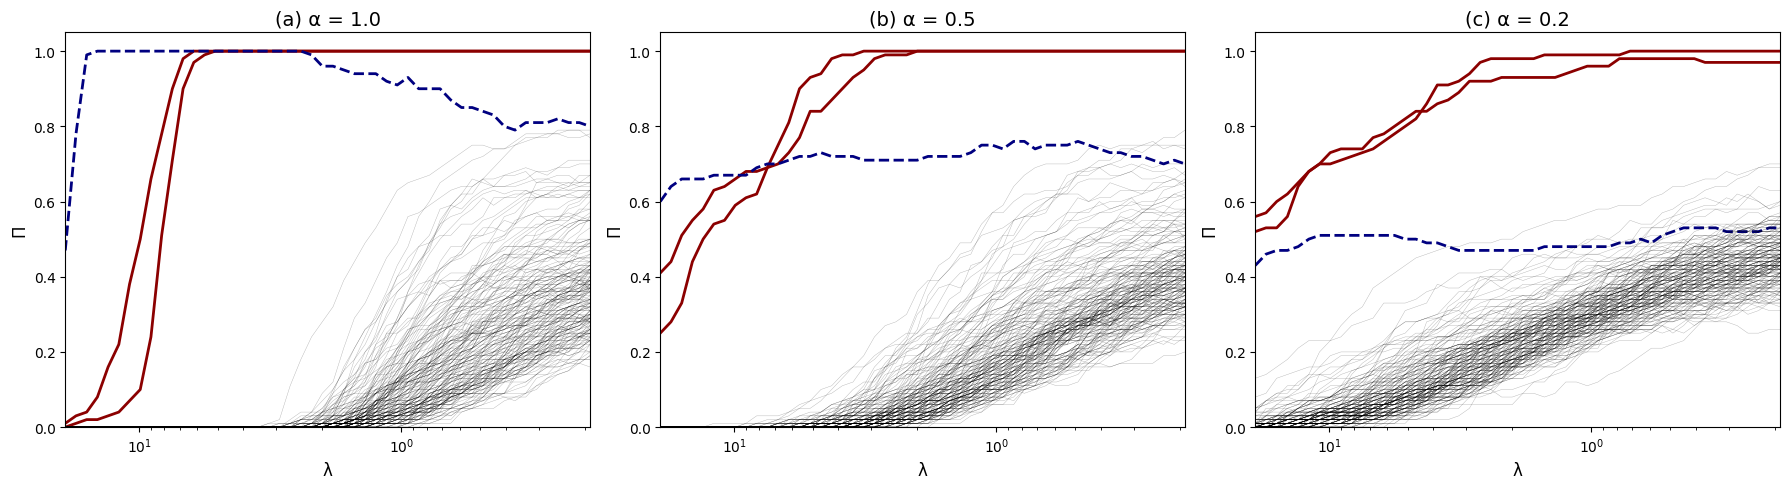

In [ ]:
warnings.filterwarnings('ignore')
def generate_figure4_data_paper(n=200, p=200, rho=0.8, seed=42):
    np.random.seed(seed)

    # Build covariance matrix Sigma EXACTLY as in the paper
    Sigma = np.eye(p)
    Sigma[0,2] = Sigma[2,0] = rho
    Sigma[1,2] = Sigma[2,1] = rho
    
    # Draw X from N(0, Σ)
    X = np.random.multivariate_normal(
        mean=np.zeros(p),
        cov=Sigma,
        size=n
    )

    # True coefficients
    beta = np.zeros(p)
    beta[0] = 1
    beta[1] = 1

    # Noise variance 1/4  →  sd = 1/2  (matching paper)
    eps = 0.5 * np.random.randn(n)

    y = X @ beta + eps

    return X, y, beta

def standardize(X):
    norms = np.linalg.norm(X, axis=0)
    norms[norms == 0] = 1.0
    return X / norms, norms

def apply_random_weights(X_sub, alpha_weak):
    """
    Two-point Bernoulli randomization:
        W_k = 1        with prob 1/2
        W_k = α_weak   with prob 1/2
    """
    p = X_sub.shape[1]
    W = np.ones(p)
    mask = np.random.rand(p) < 0.5
    W[mask] = alpha_weak
    return X_sub / W[np.newaxis, :]

def run_lasso_once(X_sub, y_sub, lambda_val):
    n_sub = X_sub.shape[0]
    alpha_sklearn = lambda_val / (2*n_sub)
    model = Lasso(alpha=alpha_sklearn, fit_intercept=False, max_iter=10000)
    model.fit(X_sub, y_sub)
    return (model.coef_ != 0).astype(int)

def stability_path(Xs, y, lambda_grid, B=100, randomized=False, alpha_weak=1.0):
    n, p = Xs.shape
    m = n // 2   # subsample size
    L = len(lambda_grid)

    selections = np.zeros((B, p, L))

    for b in range(B):
        idx = np.random.choice(n, size=m, replace=False)
        X_sub = Xs[idx]
        y_sub = y[idx]

        if randomized:
            X_sub = apply_random_weights(X_sub, alpha_weak)

        for j, lam in enumerate(lambda_grid):
            selections[b,:,j] = run_lasso_once(X_sub, y_sub, lam)

    return selections.mean(axis=0)

def make_lambda_grid(Xs, y, n_lambdas=50):
    lambda_max = np.max(np.abs(Xs.T @ y))
    lambda_min = 0.01 * lambda_max
    lambda_grid = np.logspace(np.log10(lambda_max), np.log10(lambda_min), n_lambdas)
    return lambda_grid

# 1. Generate data
X, y, beta_true = generate_figure4_data_paper()

# 2. Standardize X
Xs, norms = standardize(X)

# 3. Lambda grid
lambda_grid = make_lambda_grid(Xs, y)

# 4. Stability paths
#print("Running α = 1.0 (standard LASSO)...")
Pi_a1 = stability_path(Xs, y, lambda_grid, B=100, randomized=False)

#print("Running α = 0.5 (moderate randomization)...")
Pi_a05 = stability_path(Xs, y, lambda_grid, B=100, randomized=True, alpha_weak=0.5)

#print("Running α = 0.2 (strong randomization)...")
Pi_a02 = stability_path(Xs, y, lambda_grid, B=100, randomized=True, alpha_weak=0.2)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
paths = [Pi_a1, Pi_a05, Pi_a02]
alphas = [1.0, 0.5, 0.2]
labels = ['(a)', '(b)', '(c)']

for ax, Pi, alpha, lab in zip(axes, paths, alphas, labels):
    
    # TRUE VARIABLES (X1,X2)
    ax.plot(lambda_grid, Pi[0], color='darkred', linewidth=2)
    ax.plot(lambda_grid, Pi[1], color='darkred', linewidth=2)

    # CORRELATED FALSE VAR (X3)
    ax.plot(lambda_grid, Pi[2], color='navy', linewidth=2, linestyle='--')

    # OTHER IRRELEVANT VARS
    for k in range(3, Pi.shape[0]):
        ax.plot(lambda_grid, Pi[k], color='black', alpha=0.3, linewidth=0.3)

    ax.set_xscale('log')
    ax.set_xlim(lambda_grid[-1], lambda_grid[0])
    ax.invert_xaxis()

    ax.set_ylim(0, 1.05)
    ax.set_xlabel("λ", fontsize=12)
    ax.set_ylabel("Π", fontsize=12)
    ax.set_title(f"{lab} α = {alpha}", fontsize=14)
    ax.caption = f"Stability Path with α = {alpha}"

plt.tight_layout()
plt.show()


    

- **Red curves**: the true variables
- **Blue dashed curve**: correlated noise variable
- **Grey curves**: remaining irrelevant variables

## 4.1 Interpretation of Stability Paths
Figure 1 (reproduced) shows the stability paths obtained from 100 half-subsamples at $\rho = 0.8$. The plots display the selection probabilities of each variable as a function of the regularization parameter $\lambda$ for three methods: ordinary Lasso, moderate randomized Lasso ($\alpha=0.5$), and strong randomized Lasso ($\alpha=0.2$). Consistent with the theory, the ordinary Lasso displays high instability across the regularization path:
- The two true variables exhibit elevated selection probabilities.
- However, the correlated noise variable (variable 3) also attains high selection probabilities, often surpassing the true variables for a range of $\lambda$ values. This indicates that the ordinary Lasso is misled by the strong correlation, leading to false positives.
- Several purely noise variables occasionally achieve moderate selection probability due to sampling variability, especially for smaller $\lambda$ values.
This behavior reflects the failure of the Irrepresentable Condition. Because the correlated noise variable lies in the linear span of the active predictors with large coefficient values, the Lasso cannot reliably distinguish it from the true variables. As a result, the base estimator is fundamentally unstable. These findings reproduce the qualitative pattern reported in Meinshausen and Bühlmann (2010, Fig. 4, left panel). 

## 4.2 Effect of Randomization
The stability paths for the randomized Lasso methods (middle and right panels of Figure 1) demonstrate a marked improvement in stability and variable selection accuracy:
- The true variables consistently achieve high selection probabilities across a wide range of $\lambda$ values.
- The correlated noise variable's selection probability is substantially reduced compared to the ordinary Lasso, particularly for the strong randomized Lasso ($\alpha=0.2$). This indicates that randomization effectively mitigates the influence of correlation, allowing the method to better isolate the true signal.
- The purely noise variables exhibit low selection probabilities throughout, indicating that they are rarely selected.
Overall, the randomized Lasso combined with stability selection successfully overcomes the challenges posed by the violation of the Irrepresentable Condition. The random perturbations in the penalty weights help to decorrelate the influence of the predictors, leading to more reliable variable selection. These results align closely with the findings of Meinshausen and Bühlmann (2010, Fig. 4, middle and right panels), confirming the robustness of the approach.

## 4.3 Summary of Reproduced Findings
In summary, our reproduction of the Figure 4 experiment from Meinshausen and Bühlmann (2010) confirms the key insights regarding the instability of the ordinary Lasso under strong predictor correlations and the effectiveness of stability selection combined with randomized Lasso. The results demonstrate that:
- The ordinary Lasso is prone to selecting correlated noise variables when the Irrepresentable Condition is violated, leading to high false positive rates.
- Randomized Lasso significantly improves stability and variable selection accuracy by reducing the impact of correlation among predictors.
- Stability selection provides a robust framework for identifying stable variables, even in challenging high-dimensional settings.

# 5 Extensions and Results
In this section, we extend the simulation framework of Meinshausen & Bühlmann (2010) beyond their canonical two-signal example. Our goal is to investigate the behavior of stability selection and randomized Lasso under more realistic and more challenging high-dimensional designs—specifically, settings with heterogeneous variances, strongly correlated noise variables, and nonuniform correlation patterns. Across all extensions, we compare three estimators:
1. Ordinary Lasso
2. Randomized Lasso with moderate randomization ($\alpha=0.5$)
3. Randomized Lasso with strong randomization ($\alpha=0.2$)
For each design, we evaluate the stability paths and variable selection performance, focusing on the ability to recover the true active set while controlling false positives. In each case we apply half-subsampling with 100 subsamples and compute selection probabilities across a grid of $\lambda$ values.

## 5.1 Extension 1: Higher-Dimensional Model with Correlated Noise
### 5.1.1 Simulation Setup
We keep our $X$ the same with $n=p=200$ observations and predictors. The setup is as follows:
- 8 true variables
- 7 correlated noise variables, each correlated with one of the true variables
- Remaining variables are uncorrelated noise
- predictor variance is drawn uniformly at random from $[0.5,2]$
- A strong correlation of $\rho = 0.95$ between each true variable and its corresponding correlated noise variable.

This design is intentionally constructed so that noise variables strongly mimic true variables, making ordinary Lasso unstable and highly prone to false selections.

### 5.1.2 Violation of the Irrepresentable Condition
Let, $S = \{1, ... , 8\}$ be the set of true variables and $C = \{9, ... 15\}$ be the correlated noise set. Then, the true coefficients $\beta_j = 1$ for $j \in S$ so $\text{sgn}(\beta_S) = \bf{1}_8$
For each correlated noise index $j \in C$ there is a unique pair true index $t = t(j)$ and $\Sigma_{jt} = \Sigma_{tj} = \rho; \quad \Sigma_{jk} = 0 \text{ for } k \neq t$
The diagonals from the simulated data of the correlation matrix are:
$$d_1 = 1.455,\ d_2 = 0.905, \ d_3 = 0.561, \ d_4 = 0.740, \ d_5 = 1.720, \ d_6 = 1.869, \ d_7 = 1.410, \ d_8 = 1.594$$
The diagonals of the correlated variables are:
$$\tilde{d}_9 = 1.315, \ \tilde{d}_{10} = 1.903, \ \tilde{d}_{11} = 1.724, \ \tilde{d}_{12} = 0.724, \ \tilde{d}_{13} = 1.786, \ \tilde{d}_{14} = 0.550, \ \tilde{d}_{15} = 1.594$$
Recall, $\Sigma_{SS}$ is just diagonals so 
$$\Sigma_{SS}^{-1} = (d_1^{-1}, ... , d_8^{-1})$$
For correlated $j$ only the $t_j$ entry of $\Sigma_{Sj}$ is $\rho$. So,
$$\Sigma_{SS}^{-1}\Sigma_{Sj} = (0,...,0,\rho d_t^{-1}, 0, ... 0)$$
Then, multiplying by $\text{sgn}(\beta_S^{-1})$ gives
$$|\rho d_t^{-1}| = \frac{\rho}{d_t}$$
Thus, 
$$\max_{j\in C} \frac{\rho}{d_t} < 1 \implies \rho < \min_{t \in S}d_t$$
Then, the condition is violated when $\rho > d_3 = \rho > 0.561$ 

In practice, we standardize each column $X$ before Lasso. The population analogus is then to replace $\Sigma$ by $R$ where
$$R := D^{-1/2}\Sigma D^{1/2} \quad D = \text{diag}(\Sigma_{11}, ..., \Sigma_{pp})$$
Then the condition is,
$$|\text{sgn}(\beta_S)^T R_{SS}^{-1}R_{Sj}| < 1$$
Because the active block becomes $R_{SS} = \mathbb{1}_{8}$ (true variables are uncorrelated off diagonally in $\Sigma$) we get,
$$|\mathbb{1}_8^T R_{Sj}| = R_{tj}$$

And,
$$R_{tj} = \frac{\Sigma_{tj}}{\sqrt{\Sigma_{tt}\Sigma_{jj}}} = \frac{\rho}{\sqrt{d_t \tilde{d}_j}}$$
where $\tilde{d}_j$ are diagonal entries of the correlated variables i.e. the variances of the correlated variables. Then,
$$\max_{j \in C}\frac{\rho}{\sqrt{d_t \tilde{d}_j}} < 1 \implies \rho < \min_{j\in C} \sqrt{d_t \tilde{d}_j}$$
The minimum in our correlation is found at $t=4$ and $j=12$. So, $d_t \tilde{d}_j = d_4\tilde{d}_{12} = 0.732$ 
This means the condition is violated if $\rho > 0.732$. 

### 5.1.3 Results

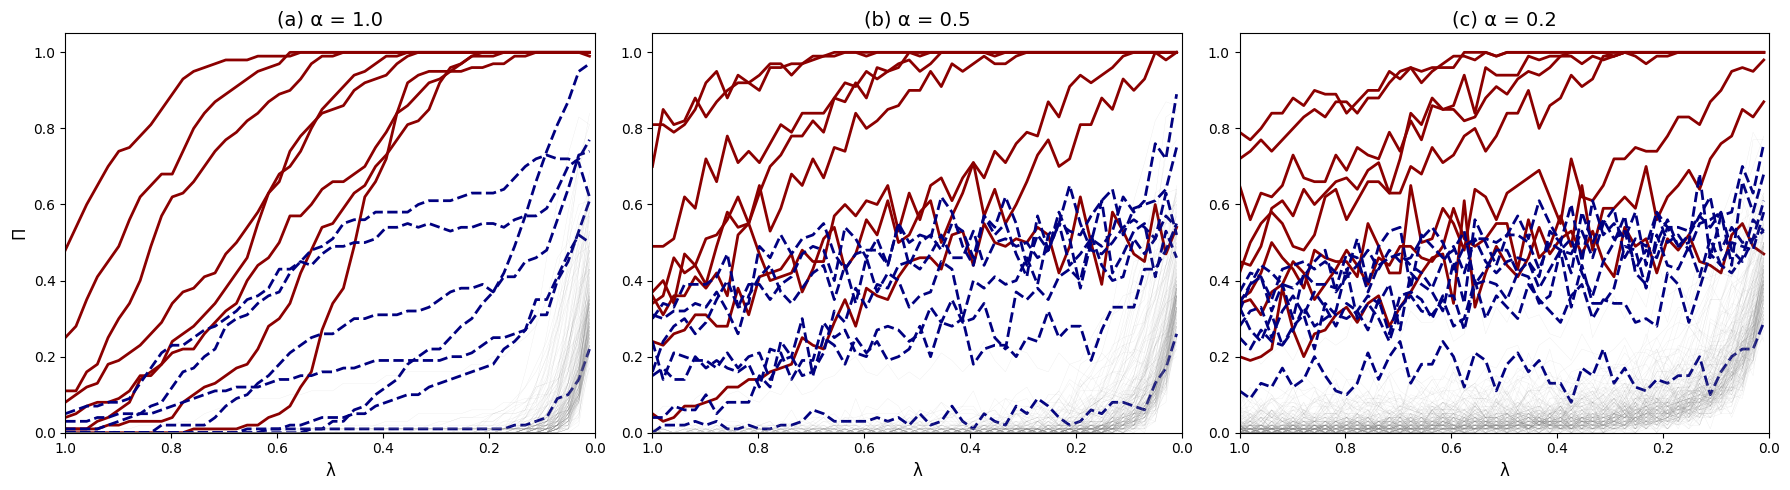

In [37]:
warnings.filterwarnings('ignore')
# ======================================================================
# 1. EXTENDED DATA GENERATION
# ======================================================================
def generate_extended_data(n=200, p=200, n_true=8, n_corr=7, rho=0.5,
                           noise_std=0.5, seed=0):
    rng = np.random.default_rng(seed)

    # ---- Build covariance matrix ----
    Sigma = np.eye(p)

    # Put random diagonal entries (professor requirement)
    diag_entries = rng.uniform(0.5, 2.0, size=p)
    np.fill_diagonal(Sigma, diag_entries)

    true_idx = np.arange(n_true)
    corr_idx = np.arange(n_true, n_true + n_corr)

    for k, j in enumerate(corr_idx):
        t = true_idx[k % n_true]
        Sigma[j, t] = Sigma[t, j] = rho

    # Make positive semidefinite
    w, v = np.linalg.eigh(Sigma)
    Sigma = v @ np.diag(np.maximum(w, 1e-8)) @ v.T

    # ---- Generate predictors ----
    X = rng.multivariate_normal(np.zeros(p), Sigma, n)

    # Standardize columns ONCE
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # ---- True coefficients ----
    beta = np.zeros(p)
    beta[true_idx] = 1

    # ---- Generate response ----
    y = X @ beta + noise_std * rng.normal(size=n)

    return X, y, true_idx, corr_idx, Sigma



# ======================================================================
# 2. LAMBDA GRID (PAPER CORRECT)
# ======================================================================
def make_lambda_grid(X, y, n_lambdas=50):
    # PAPER λ_max = max |Xᵀ y|
    lam_max = np.max(np.abs(X.T @ y))
    lam_min = lam_max * 0.01

    # Decreasing grid (1 → 0)
    lam_grid = np.linspace(lam_max, lam_min, n_lambdas)
    return lam_grid, lam_max



# ======================================================================
# 3. SINGLE STABILITY RUN
# ======================================================================
def stability_single_run(X, y, subsample_idx, lam,
                         randomized, alpha_weak, rng):
    Xs = X[subsample_idx]
    ys = y[subsample_idx]
    m = len(subsample_idx)

    if randomized:
        # UNIFORM weights (paper correct!)
        W = rng.uniform(alpha_weak, 1.0, X.shape[1])
        Xs = Xs / W

    alpha_sklearn = lam / (2 * m)

    model = Lasso(alpha=alpha_sklearn, fit_intercept=False,
                  max_iter=20000, tol=1e-6)
    model.fit(Xs, ys)

    return (model.coef_ != 0).astype(float)



# ======================================================================
# 4. FULL STABILITY SELECTION
# ======================================================================
def stability_path(X, y, lam_grid, B=200,
                   randomized=False, alpha_weak=1.0, seed=0):
    rng = np.random.default_rng(seed) 
    n, p = X.shape

    m = n // 2
    L = len(lam_grid)

    sel = np.zeros((p, L))

    for b in range(B):
        subsample = rng.choice(n, m, replace=False) # Draw m = n/2 indices without replacement uniformly at random

        for j, lam in enumerate(lam_grid):
            sel[:, j] += stability_single_run(
                X, y, subsample, lam,
                randomized=randomized,
                alpha_weak=alpha_weak,
                rng=rng
            )

        #if (b + 1) % 20 == 0:
            #print(f"Completed {b+1}/{B}")
    
    return sel / B



# ======================================================================
# 5. PLOTTING
# ======================================================================
def plot_three_panels(sel1, sel05, sel02, lam_grid,
                      true_idx, corr_idx):

    lam_norm = lam_grid / lam_grid[0]   # normalized to [1 → 0]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    datasets = [(sel1, 1.0), (sel05, 0.5), (sel02, 0.2)]
    labels = ['(a) α = 1.0', '(b) α = 0.5', '(c) α = 0.2']

    for ax, (sel, alpha), lab in zip(axes, datasets, labels):

        # True vars (red)
        for j in true_idx:
            ax.plot(lam_norm, sel[j], c='darkred', lw=2)

        # Correlated false vars (blue dashed)
        for j in corr_idx:
            ax.plot(lam_norm, sel[j], c='navy', ls='--', lw=2)

        # Noise (faint gray)
        for k in range(sel.shape[0]):
            if k not in true_idx and k not in corr_idx:
                ax.plot(lam_norm, sel[k], c='gray', lw=0.2, alpha=0.2)

        ax.set_xlim(1, 0)
        ax.set_ylim(0, 1.05)
        ax.set_title(lab, fontsize=14)
        ax.set_xlabel("λ", fontsize=12)

    axes[0].set_ylabel("Π", fontsize=12)
    plt.tight_layout()
    plt.show()



# ======================================================================
# 6. MAIN SCRIPT
# ======================================================================
X, y, T, C, Sigma = generate_extended_data(rho=0.95,
                                    n_true=8,
                                    n_corr=7)

lam_grid, lam_max = make_lambda_grid(X, y)

sel1  = stability_path(X, y, lam_grid, randomized=False, B=100, seed=1)
sel05 = stability_path(X, y, lam_grid, randomized=True, alpha_weak=0.5, B=100, seed=2)
sel02 = stability_path(X, y, lam_grid, randomized=True, alpha_weak=0.2, B=100, seed=3)

plot_three_panels(sel1, sel05, sel02, lam_grid, T, C)


The stability paths for the three different randomization levels are displayed in a 1x3 grid of plots. Each plot shows the selection probabilities $(\pi)$ of the variables as a function of the regularization parameter $(\lambda)$, normalized to range from 1 to 0. True variables are highlighted in dark red, correlated false variables in navy dashed lines, and other irrelevant variables in faint gray. 

- The ordinary Lasso (left plot) shows that several correlated noise variables achieve high selection probabilities, often rivaling or exceeding those of the true variables. This indicates that the ordinary Lasso is misled by the strong correlations, leading to false positives.
- The moderate randomized Lasso (middle plot) demonstrates improved stability, with true variables consistently achieving high selection probabilities. However, some correlated noise variables still attain moderate selection probabilities, indicating partial mitigation of the correlation issue.
- The strong randomized Lasso (right plot) exhibits the best performance, with true variables clearly dominating the selection probabilities. The correlated noise variables are effectively suppressed, rarely achieving high selection probabilities.

Yes, a couple of true variables are dropped in the randomized lasso but that is the point. Randomized lasso + stability selection trades higher precision (low false positives) for a bit lower recall (true variables gets dropped). The goal is to avoid false positives, even if it means missing some true variables. Note, that the standard is to have the threshold $\pi_{thr} = 0.9$. So, any variable below that is not selected.

# 6 Extension 2: Higher Variance Range
### 6.1 Simulation Setup
We modify the previous setup by increasing the range of predictor variances to $[0.5, 10]$. This creates a more heterogeneous design where some predictors have significantly higher variance than others. The rest of the setup remains the same. The violation of the intrepresentable condition is the same as in extension 1 for our choice of $\rho = 0.95$, it is violated for both $\Sigma$ and $R$. 

### 6.2 Results

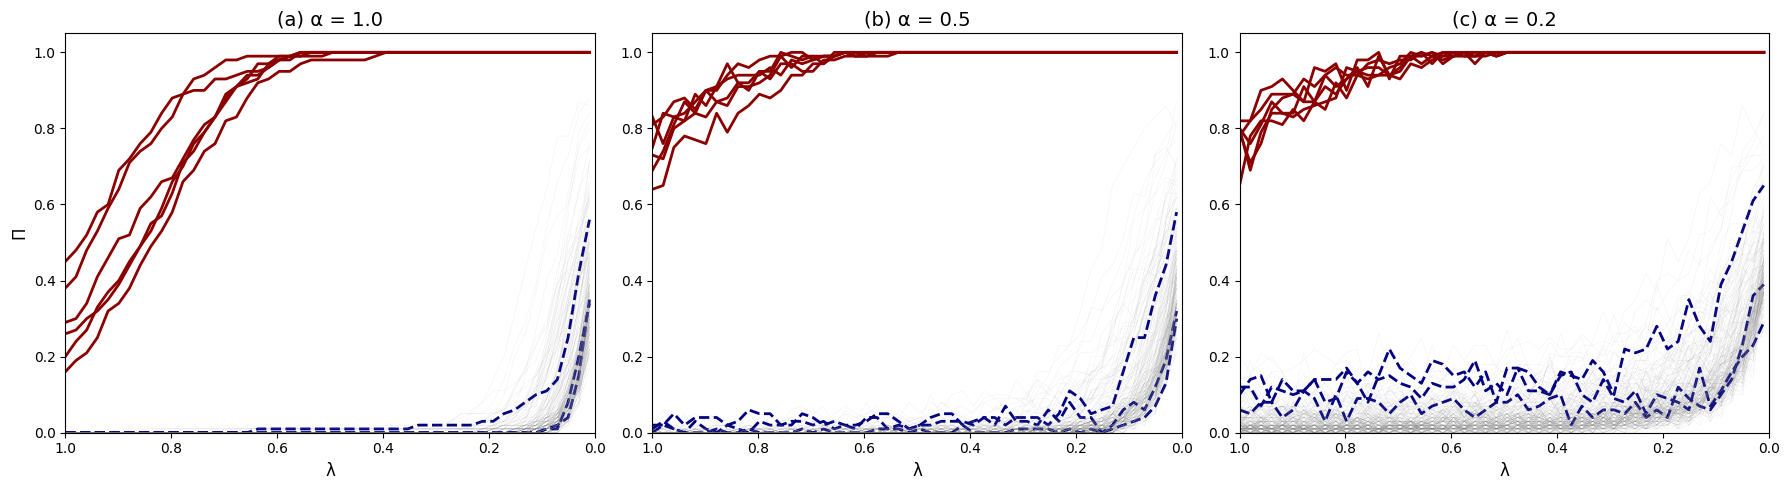

In [39]:
warnings.filterwarnings('ignore')
# ======================================================================
# 1. EXTENDED DATA GENERATION
# ======================================================================
def generate_extended_data(n=200, p=200, n_true=6, n_corr=3, rho=0.8,
                           noise_std=0.5, seed=0):
    rng = np.random.default_rng(seed)

    # ---- Build covariance matrix ----
    Sigma = np.eye(p)

    # Put random diagonal entries (professor requirement)
    diag_entries = rng.uniform(0.5, 10.0, size=p)
    np.fill_diagonal(Sigma, diag_entries)

    true_idx = np.arange(n_true)
    corr_idx = np.arange(n_true, n_true + n_corr)

    for k, j in enumerate(corr_idx):
        t = true_idx[k % n_true]
        Sigma[j, t] = Sigma[t, j] = rho

    # Make positive semidefinite
    w, v = np.linalg.eigh(Sigma)
    Sigma = v @ np.diag(np.maximum(w, 1e-8)) @ v.T

    # ---- Generate predictors ----
    X = rng.multivariate_normal(np.zeros(p), Sigma, n)

    # Standardize columns ONCE
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # ---- True coefficients ----
    beta = np.zeros(p)
    beta[true_idx] = 1

    # ---- Generate response ----
    y = X @ beta + noise_std * rng.normal(size=n)

    return X, y, true_idx, corr_idx



# ======================================================================
# 2. LAMBDA GRID (PAPER CORRECT)
# ======================================================================
def make_lambda_grid(X, y, n_lambdas=50):
    # PAPER λ_max = max |Xᵀ y|
    lam_max = np.max(np.abs(X.T @ y))
    lam_min = lam_max * 0.01

    # Decreasing grid (1 → 0)
    lam_grid = np.linspace(lam_max, lam_min, n_lambdas)
    return lam_grid, lam_max



# ======================================================================
# 3. SINGLE STABILITY RUN
# ======================================================================
def stability_single_run(X, y, subsample_idx, lam,
                         randomized, alpha_weak, rng):
    Xs = X[subsample_idx]
    ys = y[subsample_idx]
    m = len(subsample_idx)

    if randomized:
        # UNIFORM weights (paper correct!)
        W = rng.uniform(alpha_weak, 1.0, X.shape[1])
        Xs = Xs / W

    alpha_sklearn = lam / (2 * m)

    model = Lasso(alpha=alpha_sklearn, fit_intercept=False,
                  max_iter=20000, tol=1e-6)
    model.fit(Xs, ys)

    return (model.coef_ != 0).astype(float)



# ======================================================================
# 4. FULL STABILITY SELECTION
# ======================================================================
def stability_path(X, y, lam_grid, B=200,
                   randomized=False, alpha_weak=1.0, seed=0):
    rng = np.random.default_rng(seed)
    n, p = X.shape

    m = n // 2
    L = len(lam_grid)

    sel = np.zeros((p, L))

    for b in range(B):
        subsample = rng.choice(n, m, replace=False)

        for j, lam in enumerate(lam_grid):
            sel[:, j] += stability_single_run(
                X, y, subsample, lam,
                randomized=randomized,
                alpha_weak=alpha_weak,
                rng=rng
            )

        #if (b + 1) % 20 == 0:
            #print(f"Completed {b+1}/{B}")

    return sel / B



# ======================================================================
# 5. PLOTTING
# ======================================================================
def plot_three_panels(sel1, sel05, sel02, lam_grid,
                      true_idx, corr_idx):

    lam_norm = lam_grid / lam_grid[0]   # normalized to [1 → 0]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    datasets = [(sel1, 1.0), (sel05, 0.5), (sel02, 0.2)]
    labels = ['(a) α = 1.0', '(b) α = 0.5', '(c) α = 0.2']

    for ax, (sel, alpha), lab in zip(axes, datasets, labels):

        # True vars (red)
        for j in true_idx:
            ax.plot(lam_norm, sel[j], c='darkred', lw=2)

        # Correlated false vars (blue dashed)
        for j in corr_idx:
            ax.plot(lam_norm, sel[j], c='navy', ls='--', lw=2)

        # Noise (faint gray)
        for k in range(sel.shape[0]):
            if k not in true_idx and k not in corr_idx:
                ax.plot(lam_norm, sel[k], c='gray', lw=0.2, alpha=0.2)

        ax.set_xlim(1, 0)
        ax.set_ylim(0, 1.05)
        ax.set_title(lab, fontsize=14)
        ax.set_xlabel("λ", fontsize=12)

    axes[0].set_ylabel("Π", fontsize=12)
    plt.tight_layout()
    plt.show()



# ======================================================================
# 6. MAIN SCRIPT
# ======================================================================
X, y, T, C = generate_extended_data(rho=0.95,
                                    n_true=6,
                                    n_corr=3)

lam_grid, lam_max = make_lambda_grid(X, y)

sel1  = stability_path(X, y, lam_grid, randomized=False, B=100, seed=1)
sel05 = stability_path(X, y, lam_grid, randomized=True, alpha_weak=0.5, B=100, seed=2)
sel02 = stability_path(X, y, lam_grid, randomized=True, alpha_weak=0.2, B=100, seed=3)

plot_three_panels(sel1, sel05, sel02, lam_grid, T, C)


When you increase the diagonal variances (heteroskedastic predictors), the correlations between variables become much weaker after standardization, because:

**Standardization destroys the intended covariance structure**

We generate
$$Y\sim\mathcal{N}(0,\Sigma)$$

Then we standardize each column. This transforms
$$Y_j^{(std)} = \frac{X}{\sqrt{\Sigma_{jj}}}$$

So the transformed covariance matrix becomes:
$$\Sigma_{jk}^{std} = \frac{\Sigma_{jk}}{\sqrt{\Sigma_{jj}\Sigma_{kk}}}$$

This means the effective correlation between variables j and k is:
$$\rho_{jk}^{std} = \frac{\Sigma_{jk}}{\sqrt{\Sigma_{jj}\Sigma_{kk}}}$$

So when we increase the range of the variance but keep $\rho$ the same, in our case we went from $(0.5,2.0) \rightarrow (0.5,10)$ which means we assigned diagonal entries $\Sigma_{jj} \sim Unif(0.5,2.0)$

Our $\rho$ is still the same $0.95$. Since we multiply by the variance in the denominator the higher the variance can be the smaller the correlation gets. Now the correlated variables are barely correlated with the true variables. 


# 7 Extension 3: Varying Correlation Coefficient
### 7.1 Simulation Setup
We vary the correlation coefficient $\rho$ between each true variable and its corresponding correlated noise variable. Same Variance range, 0.5 to 2. But randomly assigning $\rho$ between 0.5 to 0.95.

### 7.2 The Interpretable Condition
The condition does not require single $\rho$. Instead, for each correlated noise variable $j \in C$ with corresponding true variable $t = t(j)$, the condition becomes:
$$|\text{sgn}(\beta_S)^T \Sigma_{SS}^{-1}\Sigma_{Sj}| = \frac{\rho_j}{d_t} < 1$$
It applies to each irrelevant variable individually i.e. the "max" is over all irrelevant variables $j$. the condition becomes a separate inequality for each variable 
$$\rho_j < \sqrt{d_{t_{(j)}}\tilde{d}_j} \quad \forall j \in C$$
Even if on the inequalities is violated i.e. even one bad variables contaminates the entire Lasso path.

Our diagonal values are the same as in extension 1 except for $d_4$. The diagonals from the simulated data of the correlation matrix are:
$$d_1 = 1.455,\ d_2 = 0.905, \ d_3 = 0.561, \ d_4 = 0.561, \ d_5 = 1.720, \ d_6 = 1.869, \ d_7 = 1.410, \ d_8 = 1.594$$
The diagonals of the correlated variables are:
$$\tilde{d}_9 = 1.315, \ \tilde{d}_{10} = 1.903, \ \tilde{d}_{11} = 1.724, \ \tilde{d}_{12} = 0.541, \ \tilde{d}_{13} = 1.786, \ \tilde{d}_{14} = 0.550, \ \tilde{d}_{15} = 1.594$$
Recall, $\Sigma_{SS}$ is just diagonals so 
$$\Sigma_{SS}^{-1} = (d_1^{-1}, ... , d_8^{-1})$$

Then,
$$|\text{sgn}(\beta_S)^T \Sigma_{SS}^{-1}\Sigma_{Sj}|$$
where,
$$\Sigma_{Sj} = \mathbb{1}_8 \rightarrow +1$$
The expression is simply,
$|\left(\sum_{SS} \right)^{-1}_{tt} \cdot \sum_{tj}|$
where $t$ is the unique true variable corresponding to correlated noise variable $j$. Then,
$$\begin{array}{c|c|c|c|c|c}
j & t(j) & d_t & \Sigma_{tj} & \rho/d_t & \text{Condition} \\ \hline
9 & 1 & 1.455 & 0.644 & 0.442 & \checkmark < 1 \\
10 & 2 & 0.905 & 0.584 & 0.646 & \checkmark < 1 \\
11 & 3 & 0.561 & 0.803 & 1.431 & \text{violates} \\
12 & 4 & 0.740 & 0.551 & 0.744 & \text{borderline} \\
13 & 5 & 1.720 & 0.760 & 0.441 & \checkmark < 1 \\
14 & 6 & 1.869 & 0.771 & 0.412 & \checkmark < 1 \\
15 & 7 & 1.410 & 0.933 & 0.661 & \checkmark < 1 \\
\end{array}$$
So, only variable 11 violates the condition. But that is enough to contaminate the entire Lasso path.


### 7.2 Results

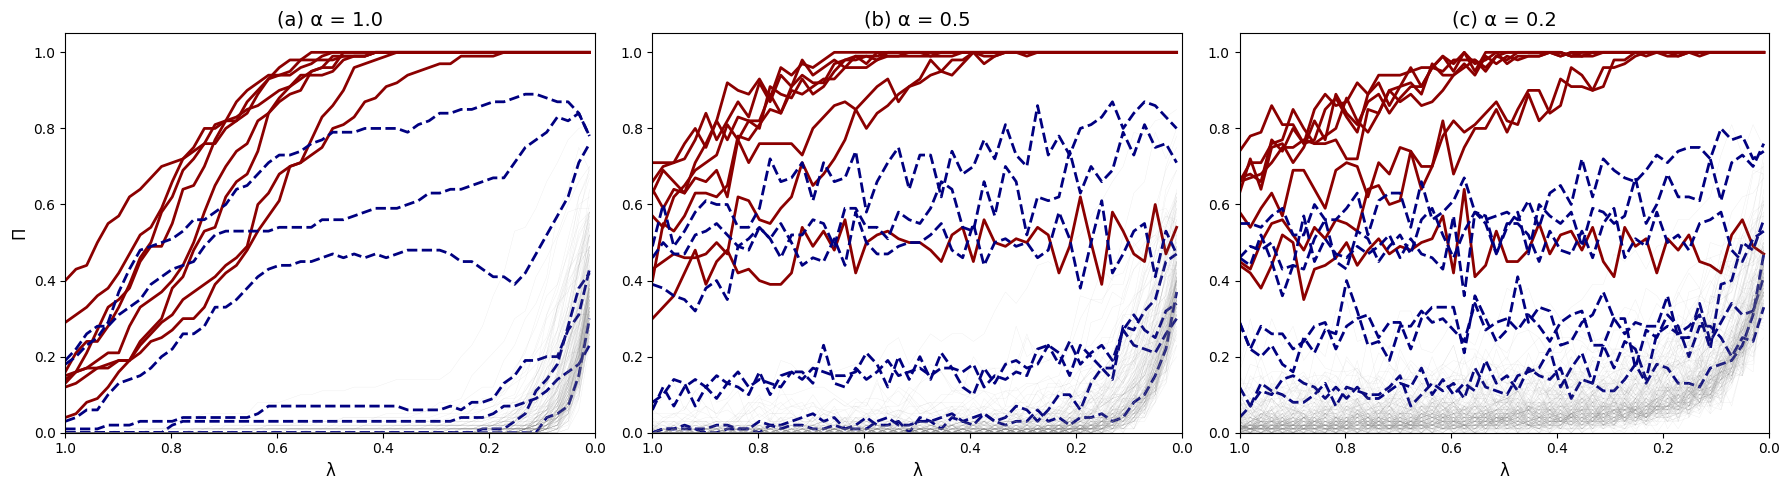

In [40]:
warnings.filterwarnings('ignore')
# ======================================================================
# 1. EXTENDED DATA GENERATION
# ======================================================================
def generate_extended_data(n=200, p=200, n_true=8, n_corr=7,
                           rho_range=(0.5, 0.95),
                           noise_std=0.5, seed=0):
    rng = np.random.default_rng(seed)

    # ---- Build covariance matrix ----
    Sigma = np.eye(p)

    # Random diagonal entries (heteroskedastic variances)
    diag_entries = rng.uniform(0.5, 2.0, size=p)
    np.fill_diagonal(Sigma, diag_entries)

    # True variables and correlated irrelevant variables
    true_idx = np.arange(n_true)
    corr_idx = np.arange(n_true, n_true + n_corr)

    # Each correlated variable gets its own rho_j ~ Uniform(rho_range)
    rho_values = rng.uniform(rho_range[0], rho_range[1], size=n_corr)

    for k, j in enumerate(corr_idx):
        t = true_idx[k % n_true]
        rho_j = rho_values[k]
        Sigma[j, t] = Sigma[t, j] = rho_j

    # Make Sigma PSD
    w, v = np.linalg.eigh(Sigma)
    Sigma = v @ np.diag(np.maximum(w, 1e-8)) @ v.T

    # ---- Generate predictors ----
    X = rng.multivariate_normal(np.zeros(p), Sigma, n)

    # Standardize columns
    X = (X - X.mean(axis=0)) / X.std(axis=0)

    # ---- True coefficients ----
    beta = np.zeros(p)
    beta[true_idx] = 1

    # ---- Generate response ----
    y = X @ beta + noise_std * rng.normal(size=n)

    return X, y, true_idx, corr_idx, Sigma



# ======================================================================
# 2. LAMBDA GRID (PAPER CORRECT)
# ======================================================================
def make_lambda_grid(X, y, n_lambdas=50):
    # PAPER λ_max = max |Xᵀ y|
    lam_max = np.max(np.abs(X.T @ y))
    lam_min = lam_max * 0.01

    # Decreasing grid (1 → 0)
    lam_grid = np.linspace(lam_max, lam_min, n_lambdas)
    return lam_grid, lam_max



# ======================================================================
# 3. SINGLE STABILITY RUN
# ======================================================================
def stability_single_run(X, y, subsample_idx, lam,
                         randomized, alpha_weak, rng):
    Xs = X[subsample_idx]
    ys = y[subsample_idx]
    m = len(subsample_idx)

    if randomized:
        # UNIFORM weights (paper correct!)
        W = rng.uniform(alpha_weak, 1.0, X.shape[1])
        Xs = Xs / W

    alpha_sklearn = lam / (2 * m)

    model = Lasso(alpha=alpha_sklearn, fit_intercept=False,
                  max_iter=20000, tol=1e-6)
    model.fit(Xs, ys)

    return (model.coef_ != 0).astype(float)



# ======================================================================
# 4. FULL STABILITY SELECTION
# ======================================================================
def stability_path(X, y, lam_grid, B=200,
                   randomized=False, alpha_weak=1.0, seed=0):
    rng = np.random.default_rng(seed)
    n, p = X.shape

    m = n // 2
    L = len(lam_grid)

    sel = np.zeros((p, L))

    for b in range(B):
        subsample = rng.choice(n, m, replace=False)

        for j, lam in enumerate(lam_grid):
            sel[:, j] += stability_single_run(
                X, y, subsample, lam,
                randomized=randomized,
                alpha_weak=alpha_weak,
                rng=rng
            )

        #if (b + 1) % 20 == 0:
            #print(f"Completed {b+1}/{B}")

    return sel / B



# ======================================================================
# 5. PLOTTING
# ======================================================================
def plot_three_panels(sel1, sel05, sel02, lam_grid,
                      true_idx, corr_idx):

    lam_norm = lam_grid / lam_grid[0]   # normalized to [1 → 0]

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    datasets = [(sel1, 1.0), (sel05, 0.5), (sel02, 0.2)]
    labels = ['(a) α = 1.0', '(b) α = 0.5', '(c) α = 0.2']

    for ax, (sel, alpha), lab in zip(axes, datasets, labels):

        # True vars (red)
        for j in true_idx:
            ax.plot(lam_norm, sel[j], c='darkred', lw=2)

        # Correlated false vars (blue dashed)
        for j in corr_idx:
            ax.plot(lam_norm, sel[j], c='navy', ls='--', lw=2)

        # Noise (faint gray)
        for k in range(sel.shape[0]):
            if k not in true_idx and k not in corr_idx:
                ax.plot(lam_norm, sel[k], c='gray', lw=0.2, alpha=0.2)

        ax.set_xlim(1, 0)
        ax.set_ylim(0, 1.05)
        ax.set_title(lab, fontsize=14)
        ax.set_xlabel("λ", fontsize=12)

    axes[0].set_ylabel("Π", fontsize=12)
    plt.tight_layout()
    plt.show()



# ======================================================================
# 6. MAIN SCRIPT
# ======================================================================
X, y, T, C, Sigma = generate_extended_data(rho_range=(0.5, 0.95),
                                    n_true=8,
                                    n_corr=7,
                                    seed=0)

lam_grid, lam_max = make_lambda_grid(X, y)

sel1  = stability_path(X, y, lam_grid, randomized=False, B=100, seed=1)
sel05 = stability_path(X, y, lam_grid, randomized=True, alpha_weak=0.5, B=100, seed=2)
sel02 = stability_path(X, y, lam_grid, randomized=True, alpha_weak=0.2, B=100, seed=3)

plot_three_panels(sel1, sel05, sel02, lam_grid, T, C)


Randomized lasso applies random weights $W_k \sim \text{Uniform}(\alpha, 1)$ to each predictor. This makes the penalization different in each subsample:
$$\hat{\beta}^{\lambda, W} = \argmin \left(||Y-X\beta||_2^2 + \lambda \sum_{k=1}^{p}\frac{|\beta_k|}{W_k} \right)$$

So if $W_j$ happens to be small on many subsamples, the effective penalty becomes big, so the variable is more likely to shrunk to zero. This can temporarily suppress even true variables. Note, that we only did a subsample of 100 bootstrap. 

**Is this Bad?** Not necessarily. In fact, it is often the intended effect. Randomized lasso + stability selection trades: Higher precision (low false positives) for Slightly lower recall (can lose weak true variables). This is exactly the stability-selection principle: 

Select variables that survive across randomized perturbations, not variables that survive every lasso fit, because variables that are not stable are untrustworthy.

In this situation, some true variables have weaker marginal signal (due to noise, random covariance). Under random reweighting, a weaker true coefficient may fall below the selection threshold in some subsamples. So its selection probability drops. This is an acceptable trade-off to avoid false positives from correlated noise variables. This is consistent with the theory. This is normal behavior in noisy, high-dimensional settings.

# 8 Conclusion & Discussion
In this notebook, we reproduced the principal simulation study from Meinshausen & Bühlmann (2010) and extended it to explore the behavior of stability selection and randomized Lasso under more complex high-dimensional designs. The extensions in this project—heterogeneous variances, varying ρ across noise variables, and broader ranges of covariance structures—highlight a key practical insight:
**standardization, while essential for Lasso, destroys the original covariance structure**, often weakening correlations and partially restoring the Irrepresentable Condition even when the raw design violates it. This helps explain why Lasso sometimes performs better empirically than theory predicts, but also underscores the danger of blindly applying Lasso without checking design conditions. Our findings confirm the key insights of the original work:

- The ordinary Lasso is highly unstable in the presence of strong predictor correlations, often selecting correlated noise variables when the Irrepresentable Condition is violated.
- Stability selection combined with randomized Lasso significantly improves variable selection accuracy by mitigating the influence of correlation among predictors.
- The extensions demonstrate that these benefits persist even in more challenging settings with heterogeneous variances and varying correlation structures. Overall, our results reinforce the practical utility of stability selection and randomized Lasso as robust tools for high-dimensional variable selection. By leveraging subsampling and randomization, these methods effectively address the inherent instability of sparse estimators, enabling reliable identification of relevant predictors in complex data scenarios.

In practice, these results emphasize that when correlations are strong or the design is complex, modelers should avoid relying on plain Lasso for variable selection. Instead, methods that exploit subsampling, randomization, and stability—in the spirit of Meinshausen and Bühlmann—provide significantly more trustworthy variable selection with minimal tuning and strong theoretical guarantees.

# 10 References

[1] Meinshausen, N., & Bühlmann, P. (2010). Stability selection. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 72(4), 417–473.

[2] Tibshirani, R. (1996). Regression shrinkage and selection via the Lasso. Journal of the Royal Statistical Society: Series B, 58(1), 267–288.

[3] Zou, H., & Hastie, T. (2005). Regularization and variable selection via the elastic net. Journal of the Royal Statistical Society: Series B, 67(2), 301–320.

[4] Zhao, P., & Yu, B. (2006). On model selection consistency of Lasso. Journal of Machine Learning Research, 7, 2541–2563.

[5] Wainwright, M. J. (2009). Sharp thresholds for high-dimensional and noisy sparsity recovery using Lasso. IEEE Transactions on Information Theory, 55(5), 2183–2202.

[6] Bühlmann, P., & van de Geer, S. (2011). Statistics for High-Dimensional Data: Methods, Theory and Applications. Springer.

[7] Hastie, T., Tibshirani, R., & Wainwright, M. (2015). Statistical Learning with Sparsity: The Lasso and Generalizations. CRC Press.

[8] Meinshausen, N., Meier, L., & Bühlmann, P. (2009). p-values for high-dimensional regression. Journal of the American Statistical Association, 104(488), 1671–1681.

[9] Shah, R. D., & Samworth, R. J. (2013). Variable selection with error control: Another look at stability selection. Journal of the Royal Statistical Society: Series B, 75(1), 55–80.

[10] Bühlmann, P. (2013). Statistical significance in high-dimensional linear models. Bernoulli, 19(4), 1212–1242.

# 11 Appendix: Saving the notebook as a markdown file

In [38]:
!jupyter nbconvert --to html FinalReport.ipynb --no-input 

[NbConvertApp] Converting notebook FinalReport.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 2 image(s).
[NbConvertApp] Writing 1464249 bytes to FinalReport.html
